In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import glob
import os
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
import time
import datetime
from scipy import signal
from scipy.signal import find_peaks
from scipy.linalg import sqrtm

In [3]:
def combine_binary(bin_list):
    combined_binary = ''.join(bin_list)
    return combined_binary

def fortyeightbit_change_o_single(result1, ave_i_0, ave_q_0, color = 'blue', color1 = 'red'):
    #result1 = api_middle_layer.demod_scatter_readback('192.168.1.223', reset=1, save_file=0, file_name='0.txt')
    #print(result1)
    result1 = np.array(result1)
    indices = np.where(result1 < 0)
    result1[indices] += 65536
    #binary_array = [int(bin(decimal)[2:].zfill(16), 2) for decimal in result1]
    binary_array = [bin(decimal)[2:].zfill(16) for decimal in result1]
#    print('binary_array:',len(binary_array))
#     print(binary_array[0:4],binary_array[256:259])
    combined_array_i = []
    combined_array_q = []
    for i in range(85):
        binary_parts_i = [binary_array[i*3+1],binary_array[i*3+2],binary_array[i*3+3]]
        binary_parts_q = [binary_array[i * 3 + 257], binary_array[i * 3 + 258], binary_array[i * 3 + 259]]
        combined_array_i.append(combine_binary(binary_parts_i))
        combined_array_q.append(combine_binary(binary_parts_q))
#     print(combined_array_i[0:1])
#     print(combined_array_q[0:1])

    decimal_array_i = []
    for binary_str in combined_array_i:
        if binary_str[0] == '1':
            decimal_value = int(binary_str, 2) - 2**48
        else:
            decimal_value = int(binary_str, 2)
        decimal_array_i.append(decimal_value)
    decimal_array_q = []
    for binary_str in combined_array_q:
        if binary_str[0] == '1':
            decimal_value = int(binary_str, 2) - 2**48
        else:
            decimal_value = int(binary_str, 2)
        decimal_array_q.append(decimal_value)
#     print(decimal_array_i[0])
#     print(decimal_array_q[0])
#     print("i",decimal_array_i)
#     print("q",decimal_array_q)
    # plt.figure()
#     plt.scatter(decimal_array_i,decimal_array_q, color = color, s = 20)  #label = 'pulse_len=16'
#     lim = max(abs(decimal_array_i[0]), abs(decimal_array_q[0]))
#     # plt.xlim(-10*lim,10*lim)
#     # plt.ylim(-2*lim,2*lim)
#     plt.xlim(-2e10,2e10)
#     plt.ylim(-2e10,2e10)
    
#     gen_i = (x for x in decimal_array_i)
#     gen_q = (y for y in decimal_array_q)
#     ave_i = sum(gen_i) / 85
#     ave_q = sum(gen_q) / 85
#     ave_ampl = math.sqrt(ave_i**2+ave_q**2)
#     ave_phase = math.atan2(ave_q,ave_i)
    single_array_ampl = []
    single_array_phase = []
    for i in range(85):
        single_array_ampl.append(math.sqrt(decimal_array_i[i]**2+decimal_array_q[i]**2))
        single_array_phase.append(math.atan2(decimal_array_i[i],decimal_array_q[i])) 
#     ave_ampl_0 = math.sqrt((ave_i-ave_i_0)**2+(ave_q-ave_q_0)**2)
#     ave_phase_0 = math.atan2(ave_q - ave_q_0,ave_i - ave_i_0)
    
#     distance_to_average_i = [np.abs(i - ave_i) for i in decimal_array_i]
#     distance_to_average_q = [np.abs(i - ave_q) for i in decimal_array_q]
    
#     ave_distance_to_average_i = sum(distance_to_average_i)/85
#     ave_distance_to_average_q = sum(distance_to_average_q)/85
#     noise_ave = math.sqrt(ave_distance_to_average_i**2+ave_distance_to_average_q**2)

#     distance_array = []
#     for i in range(85):
#         distance_array.append(np.sqrt(distance_to_average_i[i]**2 + distance_to_average_q[i]**2))
#     noise_ave = np.mean(distance_array)
#     noise_std = np.std(distance_array)
    
#     print(f"noise_ave:{noise_ave:2e}")
#     print(f"noise_std:{noise_std:2e}")
    
    
    # plt.scatter(ave_i,ave_q, color = color, s = 30)
    # lim = max(abs(ave_i), abs(ave_q))
    # plt.xlim(-2.5*lim, 2.5*lim)
    # plt.ylim(-2.5*lim, 2.5*lim)
    # plt.xlim(-1.2*lim, 1.4*lim)
    # plt.ylim(-1.2*lim, 1.4*lim)
    # plt.xlim(1e12,1.5e12)
    # plt.ylim(0e11,0.5e12)
    # print("ave_i",ave_i)
    # print("ave_q",ave_q)
#     print("ave_ampl",ave_ampl)
#     print("ave_phase",ave_phase)
#     print("\n")
    
    return single_array_ampl, single_array_phase, decimal_array_i, decimal_array_q

def process_file(file_path, ave_i_pretest, ave_q_pretest):
    """Process a single file to calculate ampl and phase."""
    df = pd.read_csv(file_path, header=None, on_bad_lines='skip')
    data_arrays = [np.array(row) for _, row in df.iterrows()]
    scatter = np.array(data_arrays)
    single_file_result = fortyeightbit_change_o_single(scatter[0], ave_i_pretest, ave_q_pretest)
    ampl_85 = single_file_result[0]
    phase_85 = single_file_result[1]
    i_85 = single_file_result[2]
    q_85 = single_file_result[3]
    return ampl_85, phase_85, i_85, q_85

def process_folder(folder_path, ave_i_pretest, ave_q_pretest, keyword = ''):
    """Process all files in a folder and calculate ampl and phase for each."""
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv') and keyword in f]
    ampl_list = []
    phase_list = []
    i_list = []
    q_list = []

    for file in files:
        ampl, phase, i, q = process_file(file, ave_i_pretest, ave_q_pretest)
        ampl_list.append(ampl)
        phase_list.append(phase)
        i_list.append(i)
        q_list.append(q)

    return ampl_list, phase_list, i_list, q_list 


In [16]:

folder_path_q1 = '/test2_C12bell_freq72.875_EQ2RQ1RQ2_campl_50_DC_0.2mA_Z/readout1/test'  # Replace with the actual folder path
folder_path_q2 = '/test2_C12bell_freq72.875_EQ2RQ1RQ2_campl_50_DC_0.2mA_Z/readout2/test2'  # Replace with the actual folder path
ave_i_pretest_q1 = 0  # 
ave_q_pretest_q1 = 0  # 
ave_i_pretest_q2 = 0  #
ave_q_pretest_q2 = 0  

ampl_list_q1, phase_list_q1, i_list_q1, q_list_q1 = process_folder(folder_path_q1, ave_i_pretest_q1, ave_q_pretest_q1)
ampl_list_q2, phase_list_q2, i_list_q2, q_list_q2 = process_folder(folder_path_q2, ave_i_pretest_q2, ave_q_pretest_q2)

# Print results
# for i, (ampl, phase) in enumerate(zip(ampl_list, phase_list)):
#     print(f"File {i+1}: ampl = {ampl}, phase = {phase}")
# print(f"average ampl {np.mean(ampl_list)}, average phase {np.mean(phase_list)}")
# print(f"average i {np.mean(i_list)}, average q {np.mean(q_list)}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(len(i_list_q1)):
    plt.scatter(i_list_q1[i], q_list_q1[i], label=f"File {i+1}", alpha=0.6)
plt.xlabel("I Quadrature")
plt.ylabel("Q Quadrature")
plt.title("IQ Plane Scatter Plot - Qubit 1")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(i_list_q2)):
    plt.scatter(i_list_q2[i], q_list_q2[i], label=f"File {i+1}", alpha=0.6)
plt.xlabel("I Quadrature")
plt.ylabel("Q Quadrature")
plt.title("IQ Plane Scatter Plot - Qubit 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

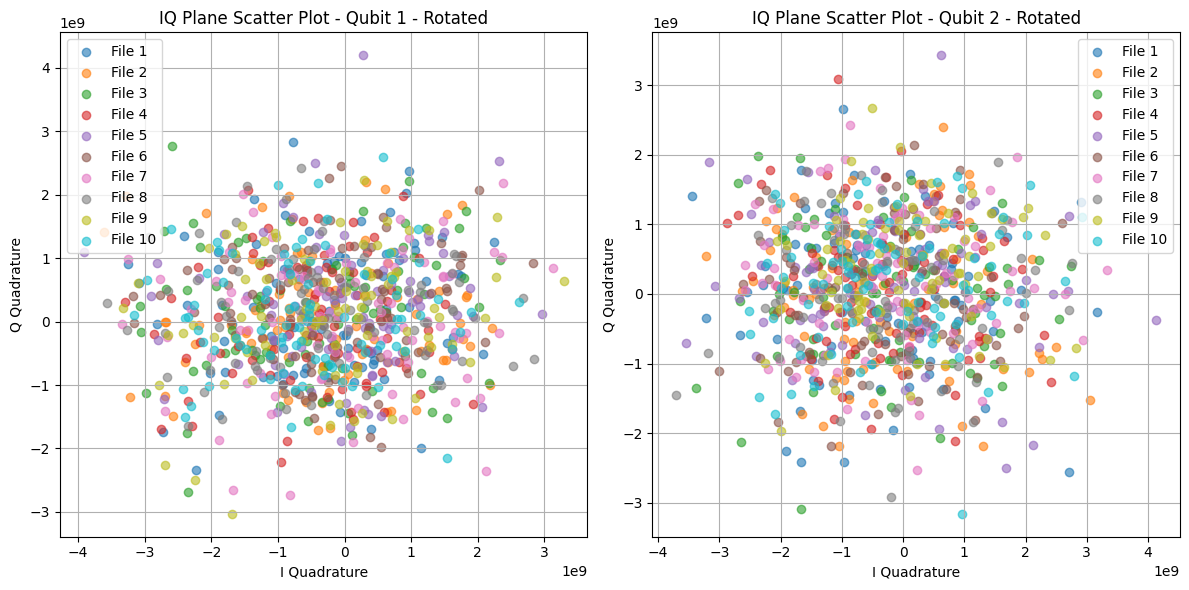

In [13]:
#rotate to I 
theta_rotate_q1 = 48
theta_rotate_q2 = 40

def rotate_iq(i_data, q_data, theta_deg):
    theta = np.radians(theta_deg)  # degree to rad
    i_data = np.array(i_data)  # Convert to numpy array
    q_data = np.array(q_data)  # Convert to numpy array
    i_rot = i_data * np.cos(theta) - q_data * np.sin(theta)
    q_rot = i_data * np.sin(theta) + q_data * np.cos(theta)
    return i_rot, q_rot

i_rotated_q1, q_rotated_q1 = rotate_iq(i_list_q1, q_list_q1, theta_rotate_q1)
i_rotated_q2, q_rotated_q2 = rotate_iq(i_list_q2, q_list_q2, theta_rotate_q2)
# print(i_rotated_q1[0],q_rotated_q1[0])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i in range(len(i_rotated_q1)):
    plt.scatter(i_rotated_q1[i], q_rotated_q1[i], label=f"File {i+1}", alpha=0.6)
plt.xlabel("I Quadrature")
plt.ylabel("Q Quadrature")
plt.title("IQ Plane Scatter Plot - Qubit 1 - Rotated")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(len(i_rotated_q2)):
    plt.scatter(i_rotated_q2[i], q_rotated_q2[i], label=f"File {i+1}", alpha=0.6)
plt.xlabel("I Quadrature")
plt.ylabel("Q Quadrature")
plt.title("IQ Plane Scatter Plot - Qubit 2 - Rotated")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

{'00': 0.28823529411764703, '01': 0.08235294117647059, '10': 0.48823529411764705, '11': 0.1411764705882353}


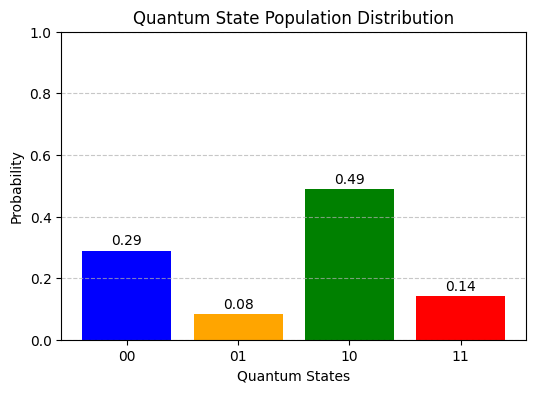

In [14]:
#set threshold
threshold_q1 = -0.665e9
threshold_q2 = 7.555e8

i_rotated_q1_1d = i_rotated_q1.flatten()
i_rotated_q2_1d = i_rotated_q2.flatten()

def analyze_qubit_states(i_rotated_q1, i_rotated_q2, threshold_q1, threshold_q2):
    counts = {"00": 0, "01": 0, "10": 0, "11": 0}

    for i1, i2 in zip(i_rotated_q1, i_rotated_q2):
        if i1 < threshold_q1 and i2 < threshold_q2:
            counts["00"] += 1
        elif i1 < threshold_q1 and i2 >= threshold_q2:
            counts["01"] += 1
        elif i1 >= threshold_q1 and i2 < threshold_q2:
            counts["10"] += 1
        else:
            counts["11"] += 1

    total = sum(counts.values())
    probabilities = {state: count / total for state, count in counts.items()}
    
    return  probabilities

probabilities = analyze_qubit_states(i_rotated_q1_1d, i_rotated_q2_1d, threshold_q1, threshold_q2)
print(probabilities)

plt.figure(figsize=(6, 4))
plt.bar(probabilities.keys(), probabilities.values(), color=['blue', 'orange', 'green', 'red'])

plt.xlabel("Quantum States")
plt.ylabel("Probability")
plt.title("Quantum State Population Distribution")
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle="--", alpha=0.7)

for state, prob in probabilities.items():
    plt.text(state, prob + 0.02, f"{prob:.2f}", ha='center', fontsize=10)

plt.show()



The density matrix is:
[[ 0.359+0.j     0.212-0.22j   0.059+0.018j -0.006-0.118j]
 [ 0.212+0.22j  -0.029+0.j     0.094+0.053j -0.088+0.141j]
 [ 0.059-0.018j  0.094-0.053j  0.429+0.j     0.088-0.073j]
 [-0.006+0.118j -0.088-0.141j  0.088+0.073j  0.241+0.j   ]]
The state fidelity is: 1.0162


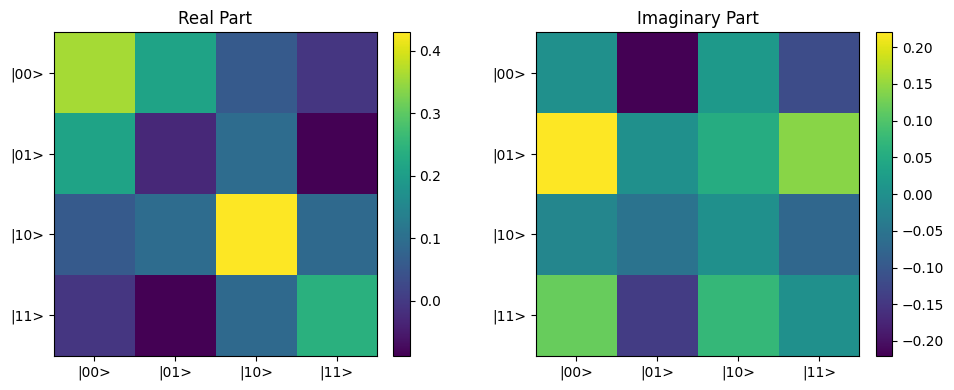

In [15]:
#2q tomo
# TODO: (sluo) test this
folder_path_q1 = 'test2_C12bell_freq72.875_EQ2RQ1RQ2_campl_50_DC_0.2mA_tomo/readout1'  #
folder_path_q2 = 'test2_C12bell_freq72.875_EQ2RQ1RQ2_campl_50_DC_0.2mA_tomo/readout2'  # 
probs = np.zeros((4, 16))
for i in range(16):
    ampl_list_q1, phase_list_q1, i_list_q1, q_list_q1 = process_folder(folder_path_q1, ave_i_pretest_q1, ave_q_pretest_q1, f"_proj{i}")
    ampl_list_q2, phase_list_q2, i_list_q2, q_list_q2 = process_folder(folder_path_q2, ave_i_pretest_q2, ave_q_pretest_q2, f"_proj{i}")
    i_rotated_q1, q_rotated_q1 = rotate_iq(i_list_q1, q_list_q1, theta_rotate_q1)
    i_rotated_q2, q_rotated_q2 = rotate_iq(i_list_q2, q_list_q2, theta_rotate_q2)
    i_rotated_q1_1d = i_rotated_q1.flatten()
    i_rotated_q2_1d = i_rotated_q2.flatten()
    probabilities = analyze_qubit_states(i_rotated_q1_1d, i_rotated_q2_1d, threshold_q1, threshold_q2)
    probs[:, i] = [probabilities["00"], probabilities["01"], probabilities["10"], probabilities["11"]]
#     print(probabilities)
# print(probs)

stokes = np.zeros(15)
for i in range(1, 16):
    if i in [1, 2, 3]:
        stokes[i - 1] = probs[0][i - 1] + probs[2][i - 1] - probs[1][i - 1] - probs[3][i - 1]
    elif i in [4, 8, 12]:
        stokes[i - 1] = probs[0][i - 1] + probs[1][i - 1] - probs[2][i - 1] - probs[3][i - 1]
    elif i in [5, 6, 7, 9, 10, 11, 13, 14, 15]:
        stokes[i - 1] = probs[0][i - 1] + probs[3][i - 1] - probs[1][i - 1] - probs[2][i - 1]
# print(stokes)

# Derive the density matrix
I = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Density matrix Pauli operator basis
II = np.kron(I, I)
IX = np.kron(I, sigma_x)
IY = np.kron(I, sigma_y)
IZ = np.kron(I, sigma_z)
XI = np.kron(sigma_x, I)
XX = np.kron(sigma_x, sigma_x)
XY = np.kron(sigma_x, sigma_y)
XZ = np.kron(sigma_x, sigma_z)
YI = np.kron(sigma_y, I)
YX = np.kron(sigma_y, sigma_x)
YY = np.kron(sigma_y, sigma_y)
YZ = np.kron(sigma_y, sigma_z)
ZI = np.kron(sigma_z, I)
ZX = np.kron(sigma_z, sigma_x)
ZY = np.kron(sigma_z, sigma_y)
ZZ = np.kron(sigma_z, sigma_z)

rho = 0.25 * (
    II
    + stokes[0] * IX
    + stokes[1] * IY
    + stokes[2] * IZ
    + stokes[3] * XI
    + stokes[4] * XX
    + stokes[5] * XY
    + stokes[6] * XZ
    + stokes[7] * YI
    + stokes[8] * YX
    + stokes[9] * YY
    + stokes[10] * YZ
    + stokes[11] * ZI
    + stokes[12] * ZX
    + stokes[13] * ZY
    + stokes[14] * ZZ
)



print(f"The density matrix is:\n{np.round(rho, decimals=3)}")

ideal_state = np.array([[0.25, 0, 0, 0], [0, 0.25, 0, 0], [0, 0, 0.25, 0], [0, 0, 0, 0.25]])
sqrt_ideal_state = sqrtm(ideal_state)
state_fidelity = (np.abs(sqrtm(sqrt_ideal_state @ rho @ sqrt_ideal_state).trace())) ** 2

print(f"The state fidelity is: {np.round(state_fidelity, decimals=4)}")


# 定义密度矩阵，基底顺序为 |00>, |01>, |10>, |11>
# rho = 0.5 * np.array([
#     [0,    0,   0,  0],
#     [0,    1, -1j, 0],
#     [0,  1j,   1,  0],
#     [0,    0,   0,  0]
# ])

rho_real = np.real(rho)
rho_imag = np.imag(rho)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
im1 = plt.imshow(rho_real, cmap='viridis', interpolation='none')
plt.title('Real Part')
plt.xticks(range(4), ['|00>', '|01>', '|10>', '|11>'])
plt.yticks(range(4), ['|00>', '|01>', '|10>', '|11>'])
plt.colorbar(im1, fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
im2 = plt.imshow(rho_imag, cmap='viridis', interpolation='none')
plt.title('Imaginary Part')
plt.xticks(range(4), ['|00>', '|01>', '|10>', '|11>'])
plt.yticks(range(4), ['|00>', '|01>', '|10>', '|11>'])
plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()